In [1]:
import tarfile
from pathlib import Path
from collections import defaultdict
import numpy as np

### Part 1: Parsing the dataset

In [2]:
# with tarfile.open('review_polarity.tar.gz', 'r:gz') as tar:
#     tar.extractall()

In [2]:
neg_filepath = './txt_sentoken/neg'
pos_filepath = './txt_sentoken/pos'

### Part 1 Comment

I put the 1000 negative/positive reviews in a list in the _result_ dictionary, in the _text_ key and -1/1 in the key of _label_. <br />
Since it is required to store the data into list/array type, I made a variable _X_raw_ and put the value of the key _text_ in it, and the value of the key _label_ for the variable _y_.     

In [3]:
results = defaultdict(list)

for file in Path(neg_filepath).iterdir():
    with open(file, "r") as file_open:
        results["text"].append(file_open.read())
        results["label"].append(-1)
        
for file in Path(pos_filepath).iterdir():
    with open(file, "r") as file_open:
        results["text"].append(file_open.read())
        results["label"].append(1)

In [4]:
X_raw = np.array(results['text'])
y = np.array(results['label'])

In [5]:
assert np.all([type(x) == np.str_ for x in X_raw])
assert len(X_raw) == y.shape[0]
assert len(np.unique(y)) == 2
assert y.min() == -1
assert y.max() == 1

## Part 2: Feature extraction

In [6]:
import re

'''
Part 2 comment

1. I cleaned the text using the function clean_text below. Then, I split each review, 
   resulting in the creation of an array named 'words' with a format like [['i', 'like', 'snow'], -> 1st review 
                                                                    ['movie', 'sentiment', 'ml'], -> 2nd review                                                                                       ..]  
2. I created the variable flatten_words to make the vocabulary set by using np.concatenate.
3. The variable 'vocab' is the unique word set. 
4. To fasten the process of word vectorization, I made each review's word list into a set first,
   which happens at the end of this cell using a for loop.  
'''

def clean_text(sentence):
    sentence = re.sub(rf'[^a-zA-Z\s]','',sentence)
    sentence = re.sub(rf"\n", "", sentence)
    sentence = re.sub(rf"\s+", " ", sentence)
    sentence = re.sub(rf'\s+[a-zA-Z]\s+', ' ', sentence)
    return sentence 


for i, text in enumerate(X_raw):
    X_raw[i] = clean_text(text)

    
words = np.array([x.split() for x in X_raw], dtype=object)
flatten_words = np.concatenate(words)
vocab = set(flatten_words)
vocab_size = len(vocab)
ordered_vocab = list(vocab)

for i, w_list in enumerate(words):
    words[i] = set(w_list)

In [7]:
'''
Here is the binary bag of words vectorization part. 
The w_list is a set and the vocab is a set. I first tried the words with a list.
It took too much time, e.g. 10 minutes, so I decided to use a set. 
The time reduced into around 1 minute. 
The variable X contains the BOW binary vectors. 
'''

len_X_raw = len(X_raw)
X = np.zeros((len_X_raw, vocab_size))
for i, w_list in enumerate(words):
    for j, v in enumerate(vocab):
        if v in w_list:
            X[i,j] = 1 

In [8]:
'''
Here is the part that I can look up the data. 
In the instruction, dolphin is not in the vocabulary. 
But I had dolphin in the vocabulary, so I tried with the word 'wifi'.
'''

lut = dict()
for i, word in enumerate(ordered_vocab):
    lut[word] = i
    
for word in ['wifi', 'the', 'coffee']:
    if word in vocab:
        print("'%s' is represented as feature dimension %i" %(word, lut[word]))
    else:
        print("'%s' is not in the vocabulary" % word)

'wifi' is not in the vocabulary
'the' is represented as feature dimension 44246
'coffee' is represented as feature dimension 37118


In [9]:
print(ordered_vocab[2000:2010])
print(X[:10, 2000:2010])
for w in ['wifi', 'the', 'coffee']:
    print("'%s' in words: %s" % (w, w in vocab))

['aversion', 'showunrelated', 'sandwiched', 'dolce', 'bounding', 'squared', 'swipe', 'beaumont', 'applause', 'tieins']
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
'wifi' in words: False
'the' in words: True
'coffee' in words: True


In [10]:
'''
Before the training, I split the X data into training and test data sets. 
For the x_train data, I used the first 800 negative reviews and the first 800 positive reviews. 
I did the same thing for the y_train and x/y test data set (20% of the X data). 

In addition, pseudo input 1 is inserted in the 0th index on the X data before the split is performed.  
'''

# pseudo input 1 
X = np.insert(X, 0, 1, axis=1)

# seperating train/test set 
x_train = np.vstack((X[0:800], X[1000:1800]))
y_train = np.hstack((y[0:800], y[1000:1800]))
x_test = np.vstack((X[800:1000], X[1800:2000]))
y_test = np.hstack((y[800:1000], y[1800:2000]))

## Part 3: Learning framework
===============================
- __About SVM Classifier model__

1. __hyperparameter__ : 

    - learning rate : 0.001 as a default
    - l2 regularization lambda : 0.001 as default
    
<br />
2. __hyperplane model__ :

    - related method(s) : def _predict_ 
    
        1. input X has a shape (2000, 46787) or (1600, 46787) for the train data  
        2. input w (weight) has a shape of (46787, 1). 
        3. When it is dot producted, it gives the predicted y, which will be used in the evaluation stage. 
    
<br />
3. __objective function__ :

    - related method(s) : def dot_matrix , def hinge_loss_matrix, def l2_regularization, def hinge_loss_function
    
        1. Method dot_matrix does the dot multiplication with weight matrix and the X data.
        2. Method hinge_loss_matrix does the sum of max in the objective function. 
        3. Method l2 regulization does the process of adding a norm on the parameter vector, <br /> which is further included in the hinge_loss_function. 
        4. Method hinge_loss_function calculates the total loss of the model. 
        
        
<br />
4. __gradient descent__ :

    - related method(s) : def gradient, def add_weight, def gradient_descent
    
        1. Method gradient calculates gradient for the weight update. 
        2. Method add_weight adds the calculated gradient and the former weight, <br /> which is multiplied by the lambda. 
        3. Finally, the method gradient_descent calculates the updated weight <br /> for the training data, which contains the learning_rate multiplication. 
        
        
<br />    
5. __training process__ : 
     - related method(s) : def fit
     
         1. reset the weight back to the normal distribution form.
         2. initial best loss is -1 which will be changed through the epoch/iteration.
         3. Until the loss hardly changes(at the end of the training), which is conditioned as loss > best_loss - 0.001,<br /> the training stops when the variable count reaches 5. 
         4. But it stopped too quickly, much sooner than I thought/desired, so I implemented min/max epoch conditions to iterate more times.
       

In [11]:
import numpy as np

class SVM_Classifier:   
     
    
    def __init__(self, weight=None, learning_rate=0.001, l2_lambda=0.001):
        self.weight = weight
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
    
    
    def predict(self, w, X):
        l = [i for i in np.dot(X, w)]
        tmp = np.sign(l)
        res = np.array([i for i in tmp])
        
        return res 
        
        
    def dot_matrix(self, w, X):
        l = [i for i in np.dot(X, w)]
        res = np.array([i for i in l])

        return res 
    
    
    def hinge_loss_matrix(self, X, labels, w):
        y_hat = self.dot_matrix(w, X)
        sum_hinge = 0
        len_of_matrix = len(X)
        for i in range(len_of_matrix):
            margins = np.max([0.0, 1 - labels[i] * y_hat[i]])
            sum_hinge += margins 
        
        return sum_hinge 
    
    
    def l2_regularization(self, w):
        sum_w = np.sum(np.square(w))
        l2 = (self.l2_lambda / 2) * sum_w
        
        return l2
    
    
    def hinge_loss_function(self, X, labels, w):
        loss = self.hinge_loss_matrix(X, labels, w)
        l2 = self.l2_regularization(w)
        total = loss + l2
        
        return total 
    
    
    def gradient(self, X, labels, w):
        sub_grad = 0
        for x_i, y_i in zip(X, labels):
            g = np.dot(x_i, w)
            if y_i * g < 1:
                sub_grad += -y_i * x_i
            else:
                sub_grad += 0
                
        return sub_grad 
    
    
    def add_weight(self, w, subgrad_w):
        subgrad_w = np.array(subgrad_w).reshape(-1, 1) #to get the same shape
        w = w * self.l2_lambda
        return w + subgrad_w 

    
    def gradient_descent(self, X, labels, w):
        sub_grads = self.gradient(X, labels, w)
        addweight = self.add_weight(w, sub_grads)
        w = w - self.learning_rate * np.array(addweight).reshape(-1, 1)
  
        return w


    def fit(self, X, labels):
        self.weight = np.random.randn(len(X[0])).reshape(-1,1)        
        best_loss = -1 # initial best loss
        count = 0
        epoch = 0 
        min_epoch = 150
        max_epoch = 250
        
        while True:
            if best_loss == -1: 
                loss = self.hinge_loss_function(X, labels, self.weight)
                best_loss = loss
                self.weight = self.gradient_descent(X, labels, self.weight)       
                loss = self.hinge_loss_function( X, labels, self.weight)
                epoch += 1
                
            else:
                if loss > best_loss - 0.001 :
                    if epoch <= min_epoch   :
                        epoch += 1
                        loss = self.hinge_loss_function( X, labels, self.weight)
                        best_loss = loss
                        self.weight = self.gradient_descent( X, labels, self.weight)
                        loss = self.hinge_loss_function( X, labels, self.weight)

                    elif epoch > min_epoch and  epoch <= max_epoch:
                        epoch += 1
                        loss = self.hinge_loss_function( X, labels, self.weight)
                        best_loss = loss
                        self.weight = self.gradient_descent( X, labels, self.weight)                      
                        loss = self.hinge_loss_function( X, labels, self.weight)
                        count += 1
                        
                        if count >= 5:
                            break
                            
                            
                    elif epoch > max_epoch:
                        break
                    
                elif loss <= best_loss - 0.001 :
                    epoch += 1
                    loss = self.hinge_loss_function( X, labels, self.weight)
                    best_loss = loss
                    self.weight = self.gradient_descent( X, labels, self.weight)
                    
                    loss = self.hinge_loss_function( X, labels, self.weight)
        
                    if epoch > max_epoch:
                        break
        
        return loss


    #calculates accuracy    
    def score(self, X, labels):
        y_hat = self.predict(self.weight, X)
        training_accuracy = np.sum(y_hat == labels.reshape(-1,1)) / len(labels)
        
        return training_accuracy

In [12]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
model = SVM_Classifier()
model.fit(X, y)
omega = model.weight

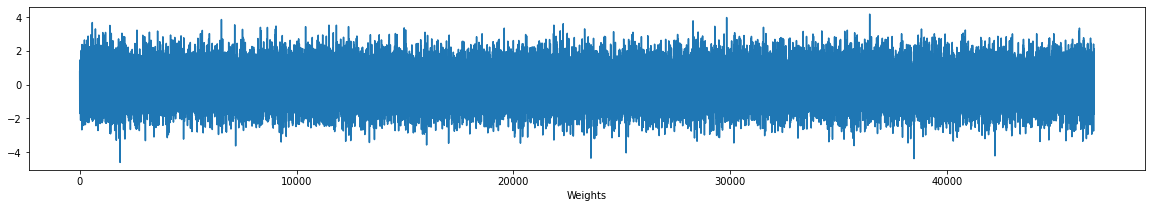

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 3))
plt.plot(omega[1:])
plt.xlabel("Value")
plt.xlabel("Weights")
plt.show()

In [14]:
assert (len(omega)-1) == len(vocab)
omega = omega.reshape(-1)
idx = np.argsort(np.abs(omega[1:]))
print("                Word   Weight  Occurences")
for i in idx[-20:]:   # Pick those with highest 'voting' values
    print("%20s   %.3f\t%i " % (ordered_vocab[i], omega[i+1], np.sum([ordered_vocab[i] in d for d in X_raw])))

                Word   Weight  Occurences
                kasi   3.466	2 
             blowing   3.503	26 
          statements   3.516	19 
         superweapon   3.519	3 
       shakespearian   3.520	1 
            exorcism   3.538	2 
                duds   -3.568	13 
          managerand   3.603	1 
           unnoticed   -3.605	8 
                mess   -3.621	316 
               clude   3.674	280 
                moms   3.774	8 
         bootlegging   3.852	1 
              curing   3.970	8 
           arbuthnot   -4.033	1 
           tributary   4.172	1 
           streeming   -4.210	1 
            invasive   -4.347	1 
               worst   -4.375	238 
              bleeth   -4.598	1 


## Word Analysis 
I would say it is a success that the model seems to have assigned significant positive weights to words such as shakespearean, curing and tributary, which would all seem to be generally used as praise in some way or another. The word with the highest polarity for determining a negative review in the model is bleeth, which upon further investigation seems to be a specific actress’ surname. If reviews that mentioned her name were consistently negative this would makes sense, but the model is significantly over-learning on specific instances of character names and actor names that occur only once. This result is caused by the characteristics of the binary BOW, which does not take account of the frequency of the words. Another case of this is the word “Arbuthnot”, which seems to be associated with negative reviews. Upon further research it seems that this is a character in Murder on the Orient Express. Another success of the way the model was trained is that it seems like words with high numbers of occurrences, like worst with 238 and mess with 316, have significant weighting toward the negative polarity of the model. 

## Part 4: Exploring hyperparameters


- __finding the best hyperparameters__

    There were many hyperparameters that reached 100% accuracy, so I made a list for the best_hyperparameter and saved all the best parameter that reached the 100%. 
    

In [16]:
learning_rate = np.exp(np.linspace(np.log(0.0001), np.log(3), 10))
reguliser_dampening = np.exp(np.linspace(np.log(0.0001), np.log(3), 10))

In [17]:
best_hyperparameters = [None]

print("Learning rate:\tReg.dampening:\tTraining set accuracy:")

for lr in learning_rate:
    for gamma in reguliser_dampening:

        model = SVM_Classifier(learning_rate = lr, l2_lambda = gamma)
        model.fit(x_train, y_train)
        training_accuracy = model.score(x_train, y_train.reshape(-1, 1))

        hyperparameters = {'learning_rate' : lr, 'regulizer_dampening' : gamma}
        if best_hyperparameters[0] is None or best_hyperparameters[0][1] < training_accuracy:
            best_hyperparameters[0] = (hyperparameters, training_accuracy)

        elif best_hyperparameters[0][1] == training_accuracy:
            best_hyperparameters.append((hyperparameters, training_accuracy))
            
        print("%.5f\t\t%.5f\t\t%.1f%%" % (hyperparameters['learning_rate'], hyperparameters['regulizer_dampening'], 100*training_accuracy))

best_learning_rate = best_hyperparameters[0][0]['learning_rate']
best_reguliser_dampening = best_hyperparameters[0][0]['regulizer_dampening']
print("Best parameters: %.5f, %.5f" % (best_learning_rate, best_reguliser_dampening))        
        

Learning rate:	Reg.dampening:	Training set accuracy:
0.00010		0.00010		74.7%
0.00010		0.00031		74.9%
0.00010		0.00099		74.9%
0.00010		0.00311		76.2%
0.00010		0.00977		75.7%
0.00010		0.03071		75.1%
0.00010		0.09655		76.6%
0.00010		0.30353		75.5%
0.00010		0.95425		75.9%
0.00010		3.00000		78.1%
0.00031		0.00010		89.2%
0.00031		0.00031		89.5%
0.00031		0.00099		92.1%
0.00031		0.00311		91.9%
0.00031		0.00977		90.8%
0.00031		0.03071		89.6%
0.00031		0.09655		90.6%
0.00031		0.30353		90.9%
0.00031		0.95425		91.4%
0.00031		3.00000		96.4%
0.00099		0.00010		91.2%
0.00099		0.00031		99.6%
0.00099		0.00099		100.0%
0.00099		0.00311		99.6%
0.00099		0.00977		99.9%
0.00099		0.03071		99.8%
0.00099		0.09655		93.0%
0.00099		0.30353		95.0%
0.00099		0.95425		100.0%
0.00099		3.00000		53.1%
0.00311		0.00010		100.0%
0.00311		0.00031		100.0%
0.00311		0.00099		100.0%
0.00311		0.00311		100.0%
0.00311		0.00977		100.0%
0.00311		0.03071		100.0%
0.00311		0.09655		100.0%
0.00311		0.30353		100.0%
0.00311		0.95425		50.0%
0

In [18]:
'''
I tried the evaluation with every hyperparameters that reached the highest accuracy in the best_hyperparameter list. 
The highest accuracy was 87.0% with few of the hyperparameters. I think it can be improved by chaning the fit method in more detailed way. 
One of the accuracy hit 50.0 % which was the lowest score despite the fact that it scored 100 % with training data. 
'''

for i in best_hyperparameters:
    model = SVM_Classifier(learning_rate = i[0]['learning_rate'], l2_lambda = i[0]['regulizer_dampening'])
    model.fit(x_train, y_train)
    test_accuracy = model.score(x_test, y_test)
    print(f"Learning rate: {model.learning_rate:.5f}\tLambda: {model.l2_lambda:.5f}\tTest set accuracy:{100*test_accuracy}")

Learning rate: 0.00099	Lambda: 0.00099	Test set accuracy:76.0
Learning rate: 0.00099	Lambda: 0.95425	Test set accuracy:74.25
Learning rate: 0.00311	Lambda: 0.00010	Test set accuracy:82.5
Learning rate: 0.00311	Lambda: 0.00031	Test set accuracy:84.0
Learning rate: 0.00311	Lambda: 0.00099	Test set accuracy:83.5
Learning rate: 0.00311	Lambda: 0.00311	Test set accuracy:85.25
Learning rate: 0.00311	Lambda: 0.00977	Test set accuracy:83.0
Learning rate: 0.00311	Lambda: 0.03071	Test set accuracy:84.25
Learning rate: 0.00311	Lambda: 0.09655	Test set accuracy:83.25
Learning rate: 0.00311	Lambda: 0.30353	Test set accuracy:85.25
Learning rate: 0.00977	Lambda: 0.00010	Test set accuracy:85.5
Learning rate: 0.00977	Lambda: 0.00031	Test set accuracy:85.0
Learning rate: 0.00977	Lambda: 0.00099	Test set accuracy:85.5
Learning rate: 0.00977	Lambda: 0.00311	Test set accuracy:86.5
Learning rate: 0.00977	Lambda: 0.00977	Test set accuracy:85.25
Learning rate: 0.00977	Lambda: 0.03071	Test set accuracy:86.75
L

## Struggles

It took at least two days to produce the gradient descent formula into the code. Finding a way to update the weight was definately the most difficult part for me. Also, keeping track of matrix dimensions was one of my struggles. 

It took so much time to find the best parameter out of 100 combinations. 

In general, I think it was educational to reimplement roughly what the scikit learn is doing for us. Following through the math and transforming it into the code definately helped me to understand the logic of the programming and reduced my fear for the math formula. And I learned how precious scikit-learn is.  